In [1]:
%%capture
from matplotlib import pyplot as plt
import numpy as np
import imageio
import base64
import io
%pylab inline

In [2]:
def image_size(image):
    if image.ndim == 2:
        return image.shape
    else:
        return image.shape[:-1]

# Lab 1
In this assignment you will perform some simple geometric transformations on images and see an application of these transformations.

Instructions:

1. Proceed cell by cell. Each cell already has some code, but it is incomplete. 
2. You are required to fill in the missing details. The places where you are expected to supply code begin and end with `# <---` and `# --->` respectively.
3. Please read the comments carefully to understand what is being asked of you.
4. All the images are inside `images/` and have already been imported. 
5. Make sure that you always do Target-Source (T-S) mapping.

## Geometric Transforms



We begin by writing a function for bilinear interpolation.

In [3]:
def bilinear_interpolation(source_image, source_point):
    """
    Computes the intensity at `source_point` by bilinearly interpolating
    intensities in the immediate 2 X 2 neighborhood of the `source_point`.
    
    Args:
        source_image (np.array): The source image
        source_point (float, float): The source point
        
    Returns:
        uint8: Pixel intensity at source_point
    """
    i_s, j_s = source_point
    
    # Floor `i_s` to get `i`
    i = int(np.floor(i_s))
    
    # Similarly, compute `j`
    # <---
    j = int(np.floor(j_s))
    # --->
    
    # The co-ordinates of the top-left (`tl`) corner are simply (i, j)
    tl = i, j
    
    # Write down the co-ordinates of the remaining three corners
    # (top-right, bottom-left, bottom-right) below.
    # Use the variable names `tr`, `bl`, `br` respectively. 
    
    # <---
    tr= i, j + 1
    bl= i + 1, j
    br= i+1,j+1
    # --->
    
    # Next, we compute the distance of `source_point` from top-left corner along
    # vertical and horizontal directions separately.
    del_i, del_j = i_s - i, j_s - j
    
    # Create a variable called `pixel_intensity` and assign the
    # pixel value obtained by bilinearly interpolating pixel values
    # at tl, tr, bl, br.
    # Use `del_i`, `del_j` computed in the previous step to obtain
    # the weights for interpolation.
    # <---
    pixel_intensity = (1 - del_i) * (1 - del_j) * source_image[tl] + (1 - del_i) * del_j * source_image[tr] + del_i * (1 - del_j) * source_image[bl] + \
del_i * del_j * source_image[br]
    # --->
    
    return np.uint8(pixel_intensity)

Next, we use the above function to implement a function that performs
an arbitrary T-S transformation on a source image.

In [4]:
def transform(source_image, transformation, target_size=None):
    """
    Transforms `source_image` as dictated by `transformation`. 
    
    Note that this function does T-S mapping. So, `transformation` is actually from Target to Source.
    
    Args:
    
        source_image (np.array): The source image
        transformation (np.array): 3 x 3 transformation matrix
        target_size (uint, uint): Size of the target_image
        
    Returns:
        np.array: Transformed image
    """
    source_rows, source_cols = image_size(source_image)
    
    # When no `target_size` is supplied, `target_image` will be the same size as `source_image`
    target_rows, target_cols = target_size if target_size else (source_rows, source_cols)
    target_image = np.zeros((target_rows, target_cols), dtype=np.uint8)
    
    # We iterate over each pixel in `target_image` and assign the appropriate intensity
    for i_t in range(target_rows):
        for j_t in range(target_cols):
            
            # Map each target point (`i_t`, `j_t`) through `transformation`
            # to obtain its corresponding source_point (`i_s`, `j_s`)
            # <---
            i_s, j_s, v = np.array([i_t, j_t, 1]) @ transformation.T
            i_s, j_s = i_s / v, j_s / v
            # --->
            
            # We ignore all target points whose source points lie outside the
            # source image. All these intensities remain 0.
            if 0 <= i_s < source_rows - 1 and 0 <= j_s < source_cols - 1:
                # Assign the intensity value of target_image at (i_t, j_t) using the
                # bilinear interpolation function above.
                
                # <---
                target_image[i_t, j_t] = bilinear_interpolation(source_image, (i_s, j_s))
                # --->
    
    return target_image

### 1. Translate `lena_translate.png` by ($t_i = 3.3, t_j = 4.75$) pixels.

In [5]:
def translate(source_image, t_i, t_j):
    """
    Translates the `source_image` by `t_i` pixels along rows and by `t_j` along columns.
    
    
    Args:
        source_image (np.array): The source image
        t_i (float): translation along rows
        t_j (float): translation along columns
        
    Returns:
        np.array: Translated image
    """
    # Create a variable called `translation` which holds a 3 x 3
    # numpy array that corresponds to translation of t_i along rows
    # and t_j along columns. Note that this matrix should be 
    # T-S, so it would be the inverse of what you might think of for
    # an S-T translation matrix.
    
    # <---
    translation = np.array([[1, 0, -t_i], [0, 1, -t_j], [0, 0, 1]])
    # --->
    
    return transform(source_image, translation)

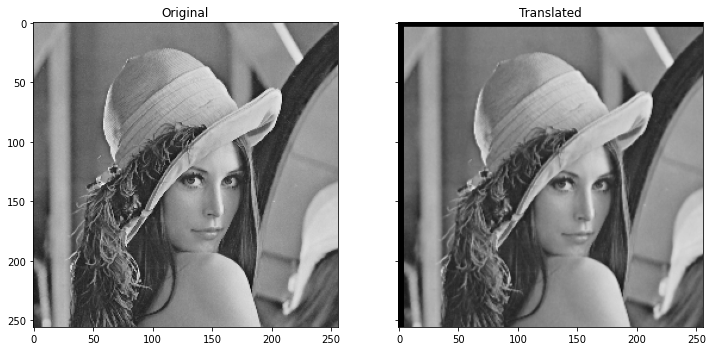

In [6]:
lena = imageio.imread('./lena.png', format='PNG')
# Call the `translate` function above with the right parameters.
# <---
lena_translated = translate(lena,3.3,4.75)
# --->
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 25))

ax1.imshow(lena, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

ax2.imshow(lena_translated, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Translated')

plt.show()

### 2. Rotate `pisa_rotate.png` about the image centre, so as to straighten the Pisa tower.

In [7]:
def rotate(source_image, theta):
    """
    Rotates the `source_image` by `theta` in counter clockwise direction.
    
    
    Args:
        source_image (np.array): The source image
        theta (float): Angle of rotation (in degrees)
        
    Returns:
        np.array: Rotated image
    """
    theta *= np.pi/ 180
    num_rows, num_cols = image_size(source_image)
    
    # Create a variable called `rotation` which holds a 3 x 3
    # numpy array that corresponds to rotation by `theta` 
    # Note that this matrix should be T-S,
    # so it would be the inverse of what you might think of for
    # an S-T rotation matrix.
    
    # <---
    rotation = np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    # --->
    
    # We pre and post multiply by some translation matrices
    # because we want the rotation to be about the center, not
    # the top-left of the image which is the origin in our co-ordinate system
    transformation = np.array([[1, 0, num_rows / 2],
                               [0, 1, num_cols / 2],
                               [0, 0, 1]]) @ \
                     rotation @ \
                     np.array([[1, 0, -num_rows / 2],
                               [0, 1, -num_cols / 2],
                               [0, 0, 1]])
    return transform(source_image, transformation)

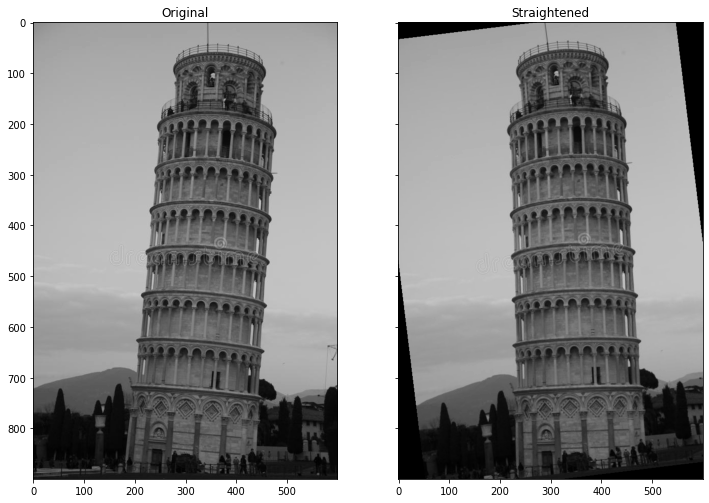

In [8]:
pisa = imageio.imread('./pisa.jpg', format='JPG')

# Call the `rotate` function above with the right parameters.
# <---
pisa_rotated = rotate(pisa,7)
# --->
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 25))

ax1.imshow(pisa, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

ax2.imshow(pisa_rotated, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Straightened')

plt.show()

### 3. Scale `cells_scale.png` by 1.8 and 0.3 factors.

In [9]:
def scale(source_image, factor):
    """
    Scales the `source_image` by `factor` in both dimensions.
    
    
    Args:
        source_image (np.array): The source image
        factor (float): Scaling factor.
        
    Returns:
        np.array: Scaled image
    """
    
    # Create a variable called `scaling` which holds a 3 x 3
    # numpy array that corresponds to scaling by factor 
    # Note that this matrix should be T-S,
    # so it would be the inverse of what you might think of for
    # an S-T scaling matrix.
    
    # <---
    scaling = np.array([[1 / factor, 0, 0], [0, 1 / factor, 0], [0, 0, 1]])
    # --->
    
    return transform(source_image, scaling)

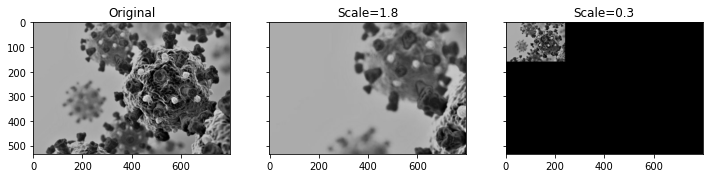

In [10]:
cells = imageio.imread('./sars-covid19.jpeg', format='JPEG')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 25))

ax1.imshow(cells, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('Original')

# Call the `scale` function above to scale by 1.8
# <---
cells_scaled =  scale(cells, 1.8)
# --->
ax2.imshow(cells_scaled, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('Scale=1.8')

# Call the `scale` function above to scale by 0.3
# <---
cells_scaled =  scale(cells, 0.3)
# --->
ax3.imshow(cells_scaled, cmap=plt.cm.gray, vmin=0, vmax=255)
ax3.set_title('Scale=0.3')

plt.show()